In [18]:
import os
import pandas as pd
import pickle
from importlib import reload
import lime.lime_rdf
from rdflimeConfig import movieLocation
import logging 

logging.basicConfig(level=logging.INFO)

movieFull = pd.read_csv(os.path.join(movieLocation, "movies_fixed.tsv"), sep="\t")
movies = [movie.DBpedia_URI for _, movie in movieFull.iterrows()]

In [19]:
pcopy = lambda o: pickle.loads(pickle.dumps(o))

In [45]:
reload(lime.lime_rdf)
from lime.lime_rdf import LimeRdfExplainer

with open(os.path.join(movieLocation, "transformers", "rdf2vec_transformer_cbow_200"), "rb") as file:
    rdf2vec_transformer = pickle.load(file)

with open(os.path.join(movieLocation, "classifiers", "svc_100_cbow_200"), "rb") as file:
    clf = pickle.load(file)

explainer = LimeRdfExplainer(
    transformer=rdf2vec_transformer, 
    entities=movies,
    class_names=clf.classes_,
    kernel=None,
    kernel_width=25,
    verbose=False,
    feature_selection="auto",
    random_state=42
)

explained_entity_id = 100  # 0-400 -> test data
explained_entity_uri = movies[explained_entity_id]
prediction = clf.predict_proba([rdf2vec_transformer._embeddings[explained_entity_id]])

print("Explaining", explained_entity_uri)
print("Original prediction:", prediction, " / ".join(clf.classes_))
print("True class:", movieFull.iloc[explained_entity_id].label)

"""
Grid search
ids = [1662, 1735, 1796, 1856, 1935]
max_removed_triples = [1, 10, 25, 100]
removal_count_fixed = [True, False]
use_w2v_freeze = [True, False]
center_correction = [True, False]
center_init = [True, False]
single_run = [True, False]
"""

data, labels, distances, explanation = explainer.explain_instance(
    entity=explained_entity_uri, 
    classifier_fn=clf.predict_proba,
    num_features=20,
    num_samples=5000,
    max_removed_triples=3,
    removal_count_fixed=True,
    use_w2v_freeze=True,
    center_correction=False,
    single_run=False,
    train_with_all=False,
    distance_metric="cosine",
    model_regressor=None,
    short_uris=True
)

Explaining http://dbpedia.org/resource/Welcome_to_Sarajevo
Original prediction: [[0.34332854 0.65667146]] bad / good
True class: good


100%|██████████| 5000/5000 [00:21<00:00, 227.77it/s]


Average remaining walks per artificial entity (from 484): 470.3406


100%|██████████| 5000/5000 [16:41<00:00,  4.99it/s]


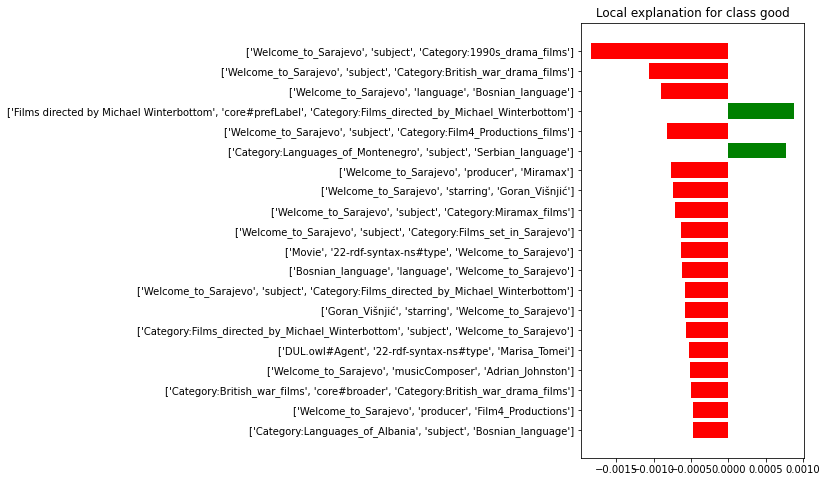

In [46]:
figsize = (4, .4*len(explanation.as_list()))
fig = explanation.as_pyplot_figure(figsize=figsize)

In [38]:
explanation.as_list()

[(['Category:English_male_voice_actors', 'subject', 'Stephen_Dillane'],
  -0.000524815802083625),
 (['New_York_City', 'location', 'Miramax'], -0.0005187639413237662),
 (['Category:Living_people', 'subject', 'Kerry_Fox'], -0.00045452634130163536),
 (['Romania', 'spokenIn', 'Croatian_language'], -0.0004403923122330902),
 (['Person', '22-rdf-syntax-ns#type', 'Michael_Winterbottom'],
  0.0004304909050008029),
 (['Serbia', 'spokenIn', 'Bosnian_language'], -0.00036771210247515045),
 (['Warner Bros. films', 'core#prefLabel', 'Category:Warner_Bros._films'],
  -0.0003549213670893021),
 (['Miramax films', 'core#prefLabel', 'Category:Miramax_films'],
  0.000310385568776668),
 (['Serbian_language', 'language', 'Welcome_to_Sarajevo'],
  0.0002969472720182963),
 (['Bosnian_language', 'language', 'Welcome_to_Sarajevo'],
  -0.0002959786012741592),
 (['Welcome_to_Sarajevo', 'distributor', 'Miramax'], -0.0002890892119331465),
 (['Wish_You_Were_Here_(1987_film)', 'award', 'Emily_Lloyd'],
  -0.00026992941

<AxesSubplot:>

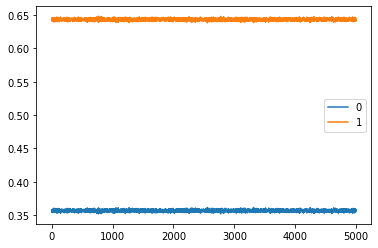

In [47]:
pd.DataFrame(labels).plot()

# thesis: show plot with/without single_run

In [95]:
iw = explainer.indexed_walks

x = [e[0] for e in ex] #list(iw.walks_as_triples(iw.walks(explained_entity_uri)))

cmax = ex[0][1]
cols = [[e[1]/cmax,0,0] if e[1] < 0 else [0,-e[1]/cmax,0,0] for e in ex]

edges = [[i[0].split("/")[-1], i[2].split("/")[-1]] for i in x]
labels = [i[1].split("/")[-1] for i in x]

print(labels[3])
edges[3]

core#prefLabel


['Films directed by Michael Winterbottom',
 'Category:Films_directed_by_Michael_Winterbottom']

[[0.46839627838173475, 0, 0],
 [0.2693055535030339, 0, 0],
 [0.230363765318241, 0, 0],
 [0, 0.2232993310956382, 0, 0],
 [0.20902990625594034, 0, 0],
 [0, 0.19716256259559828, 0, 0],
 [0.19559710567608848, 0, 0],
 [0.18721405788429307, 0, 0],
 [0.18347370555437037, 0, 0],
 [0.16187622494308468, 0, 0],
 [0.1618575949463812, 0, 0],
 [0.1573140247922106, 0, 0],
 [0.1490077345146777, 0, 0],
 [0.14788128045659069, 0, 0],
 [0.14319939022077488, 0, 0],
 [0.1338229686913647, 0, 0],
 [0.1293158023755167, 0, 0],
 [0.12739648017796307, 0, 0],
 [0.11953774459181708, 0, 0],
 [0.11909220279052751, 0, 0]]

In [94]:
cols

[[-1.0, 0, 0],
 [-0.5749523767213937, 0, 0],
 [-0.49181382506736865, 0, 0],
 [0, -0.47673165095827935, 0, 0],
 [-0.4462672226562497, 0, 0],
 [0, -0.4209311040573944, 0, 0],
 [-0.41758894061212043, 0, 0],
 [-0.39969159988012737, 0, 0],
 [-0.3917061557112598, 0, 0],
 [-0.345596735956895, 0, 0],
 [-0.34555696195021873, 0, 0],
 [-0.3358566924052339, 0, 0],
 [-0.318123224696587, 0, 0],
 [-0.315718307941102, 0, 0],
 [-0.30572273271580075, 0, 0],
 [-0.28570459430999434, 0, 0],
 [-0.2760820449348801, 0, 0],
 [-0.2719843988045891, 0, 0],
 [-0.25520643546701266, 0, 0],
 [-0.2542552285043338, 0, 0]]

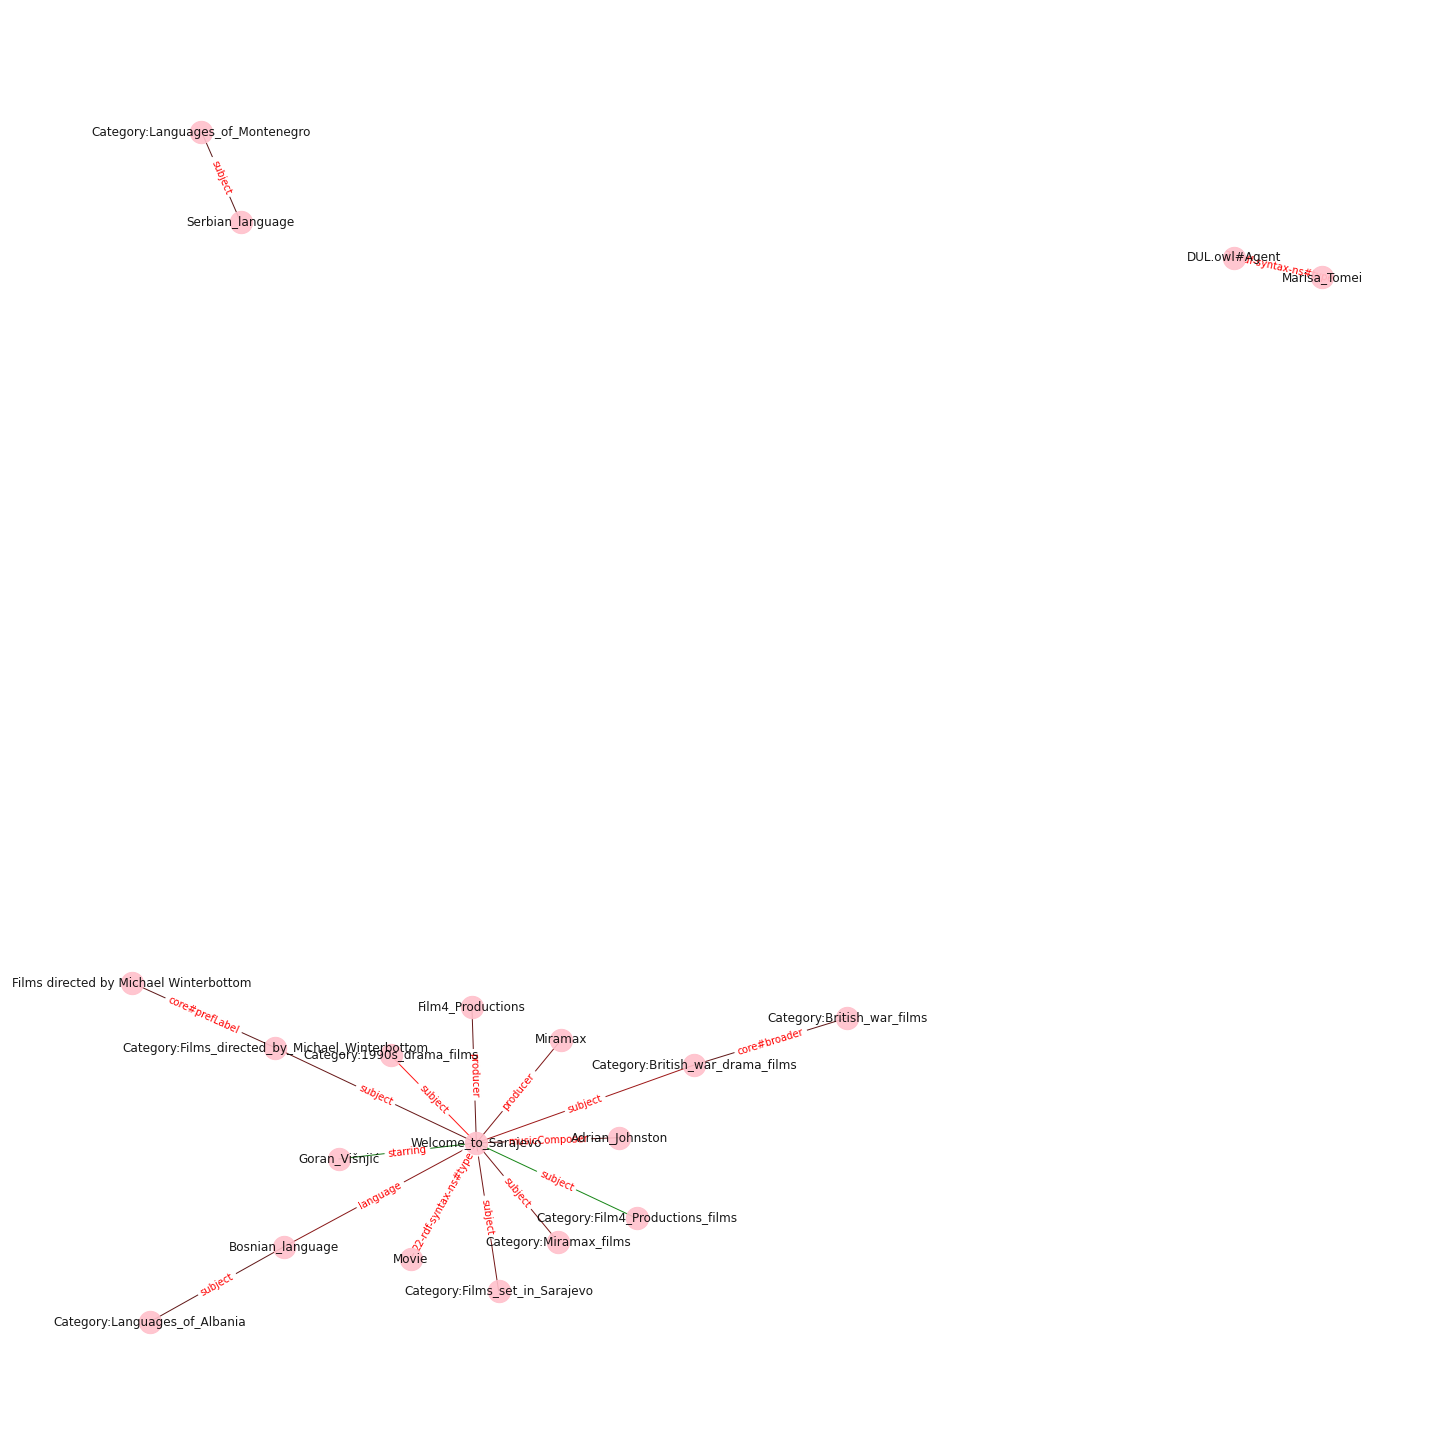

In [96]:
import matplotlib.pyplot as plt
import networkx as nx


ex = explanation.as_list()

z = {}
colors = []
for edge, label in zip(edges, labels):
    z[frozenset(edge)] = label


G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
plt.figure(figsize=(20,20))
nx.draw(
    G, pos, edge_color=cols, width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)


_ = nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=z,
    font_color='red'
)

from pyvis.network import Network
nt = Network('500px', '500px')
nt.from_nx(G)
nt.show("nx.html")

In [65]:
wv_old = explainer.old_transformer.embedder._model.wv
wv_new = explainer.transformer.embedder._model.wv
def embedding(URI, new):
    wv = wv_new if new else wv_old
    return wv.get_vector(URI)

AttributeError: 'LimeRdfExplainer' object has no attribute 'old_transformer'

In [33]:
wv_old.most_similar(explainer.new_embeddings[150])

[('http://dbpedia.org/resource/Cabin_Boy', 0.9890596866607666),
 ('http://dbpedia.org/resource/Sorority_Boys', 0.5968995094299316),
 ('http://dbpedia.org/resource/Deuce_Bigalow:_Male_Gigolo',
  0.5358062982559204),
 ('http://dbpedia.org/resource/Spy_Hard', 0.5242369174957275),
 ('http://dbpedia.org/resource/The_Hot_Chick', 0.5176414847373962),
 ('http://dbpedia.org/resource/Bringing_Down_the_House_(film)',
  0.5109054446220398),
 ('http://dbpedia.org/resource/Surviving_Christmas', 0.5081382989883423),
 ("http://dbpedia.org/resource/Catherine_O'Hara", 0.5072921514511108),
 ('http://dbpedia.org/resource/Mixed_Nuts', 0.49615809321403503),
 ('http://dbpedia.org/resource/Love_Stinks_(film)', 0.4926844835281372)]

In [14]:
# Check if the movie embedding itself drifted
all(embedding(explained_entity_uri, new=True) == embedding(explained_entity_uri, new=False))

True

In [24]:
for walk in explainer.indexedWalks.walks(e):
    for step in walk:
        if not step in changed and not step == e:
            print(step)

In [160]:
drifted = 0
changed = []

for i in range(len(wv_old)):
    if not (wv_old[i] == wv_new[i]).all():
        changed.append(wv_new.index_to_key[i])

        drifted += 1

print(drifted) 

198


In [3]:
explainer.transformer.embedder._model.wv.most_similar(explainer.new_embeddings[0])

[('http://dbpedia.org/resource/Cabin_Boy', 0.8919827342033386),
 ('http://dbpedia.org/resource/Sorority_Boys', 0.4870971739292145),
 ('http://dbpedia.org/resource/Deuce_Bigalow:_Male_Gigolo',
  0.4668467938899994),
 ('http://dbpedia.org/resource/Confessions_of_a_Shopaholic_(film)',
  0.4478405714035034),
 ('http://dbpedia.org/resource/Bringing_Down_the_House_(film)',
  0.44290289282798767),
 ('http://dbpedia.org/resource/Just_Visiting_(film)', 0.42650309205055237),
 ('http://dbpedia.org/resource/The_Hot_Chick', 0.41822385787963867),
 ('http://dbpedia.org/resource/Category:Disney_films', 0.4161430597305298),
 ('http://dbpedia.org/resource/Two_Girls_and_a_Guy', 0.410209059715271),
 ('http://dbpedia.org/resource/Category:American_military_personnel_of_the_Vietnam_War',
  0.4044659435749054)]

In [36]:
len(explainer.old_transformer._embeddings + explainer.new_embeddings)

4500

/home/vscode/.cache/pypoetry/virtualenvs/rdflime-util-gHAPOX-U-py3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vscode/.cache/pypoetry/virtualenvs/rdflime-util-gHAPOX-U-py3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


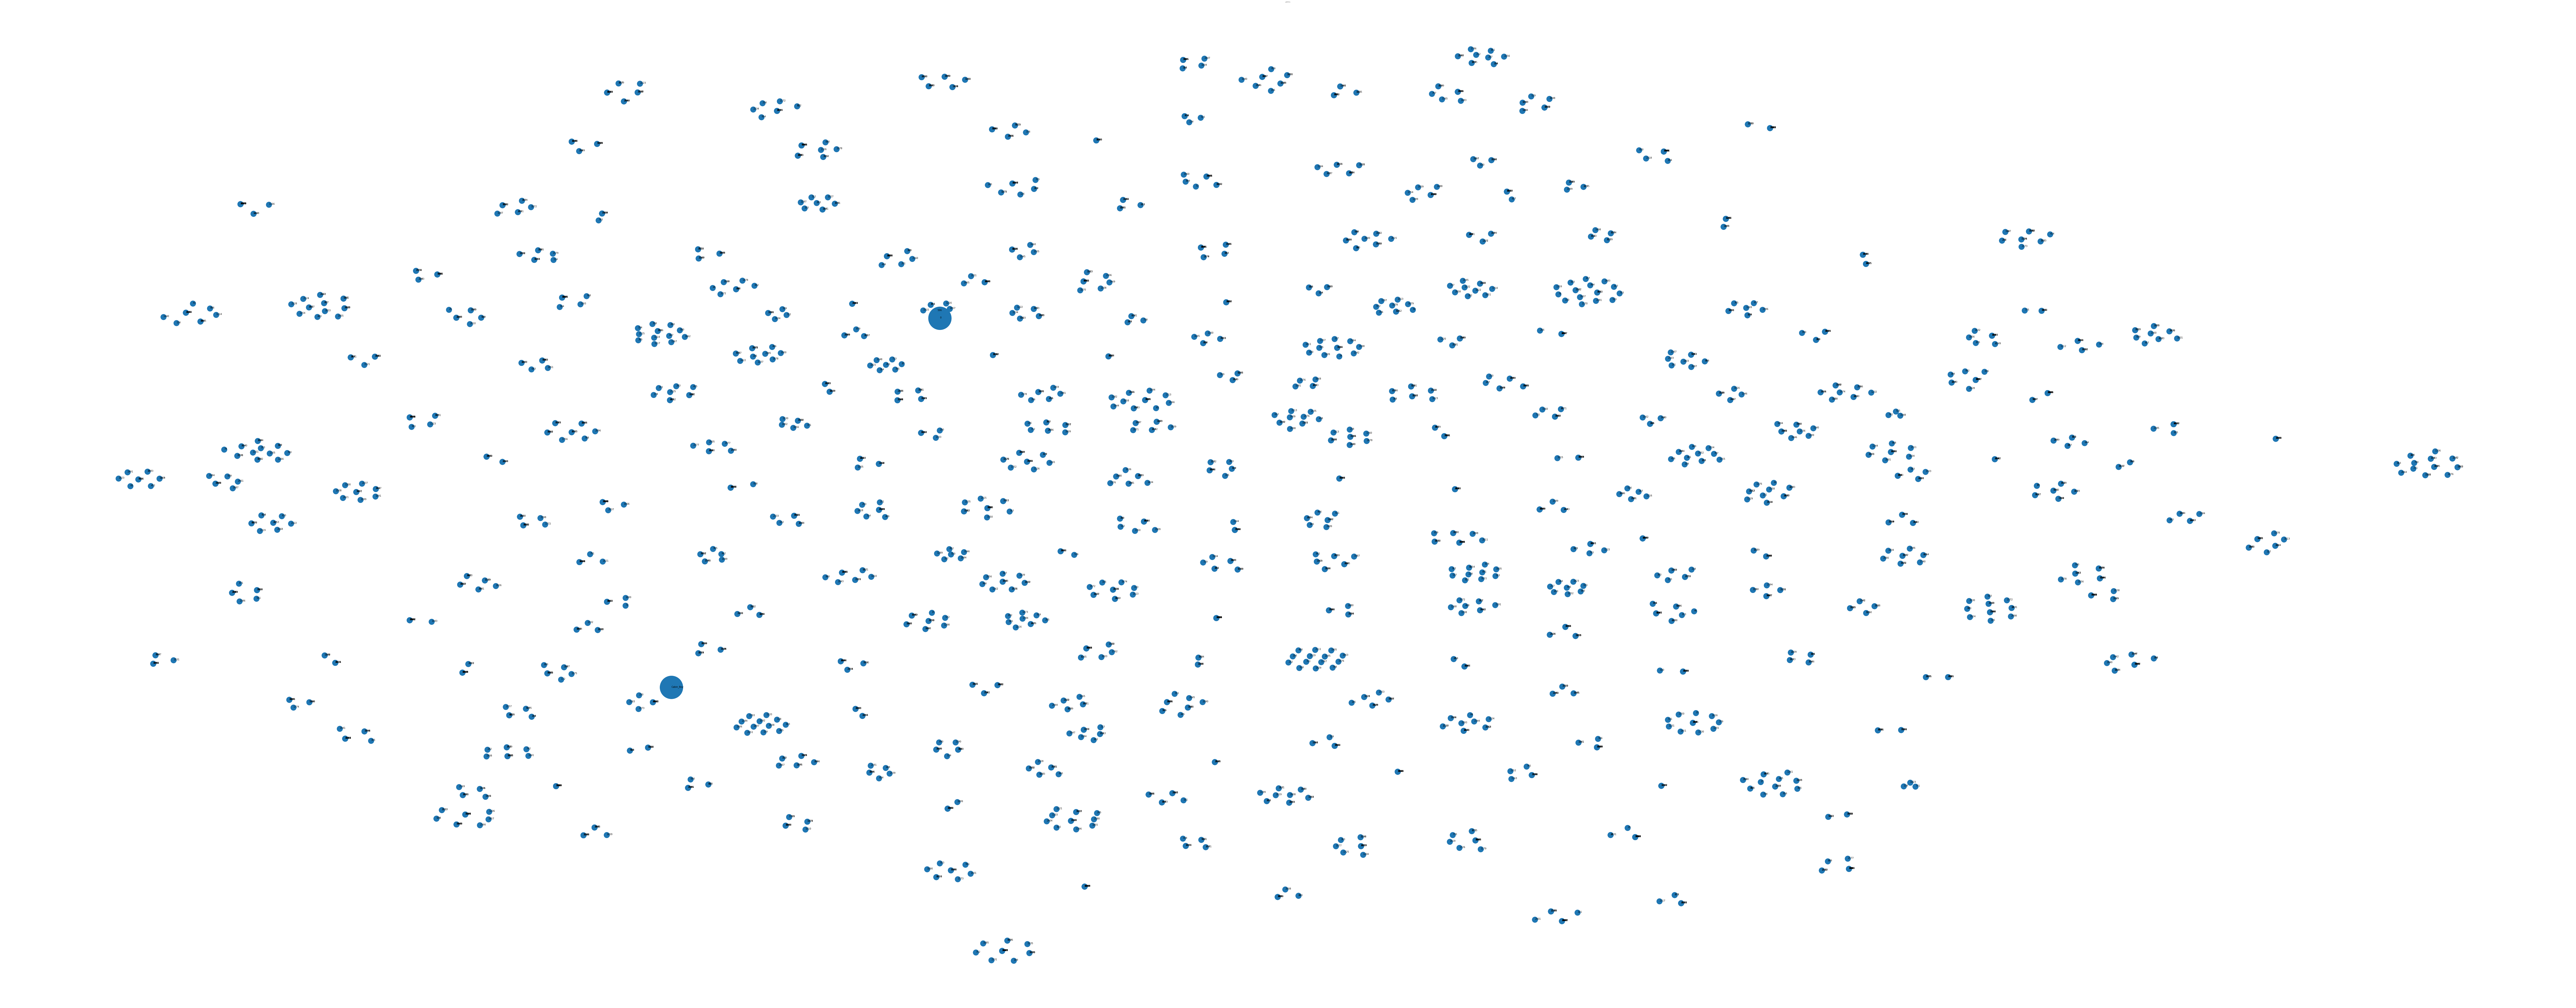

In [53]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
# Reduce the dimensions of entity embeddings to represent them in a 2D plane.
X_tsne = TSNE(random_state=42).fit_transform([wv_old[explained_entity_uri]] + explainer.new_embeddings)

labels = explainer.old_transformer._entities + list(range(len(explainer.new_embeddings)))
labels = [explained_entity_uri] + list(range(len(explainer.new_embeddings)))

#colors = list(map(lambda e: "#00ff00" if movieTest[movieTest.DBpedia_URI==e].iloc[0].label == "good" else "#ff0000", transformer._entities[1600:]))
#sizes = list(map(lambda e: abs(50-movieTest[movieTest.DBpedia_URI==e].iloc[0].rating)**2, transformer._entities[1600:]))
sizes = list(map(lambda l: 100**2 if l == explained_entity_uri or l == 0 else 25**2, labels))

# Ploy the embeddings of entities in a 2D plane, annotating them.
f = plt.figure(figsize=(200, 80))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=sizes)#, c=colors, s=sizes)

for x, y, t in zip(X_tsne[:, 0], X_tsne[:, 1], labels):
    if type(t) == str and "http" in t: t = t.split("/")[-1]
    plt.annotate(t, (x, y))

# Display the graph with a title, removing the axes for better readability.
plt.title("pyRDF2Vec", fontsize=4)
plt.axis("off")
plt.show()

#f.savefig("figure.pdf", bbox_inches='tight')


In [4]:
import numpy as np



In [5]:
with open("corpus.text", "wb") as f:
    pickle.dump(corpus, f)
    

Error: Canceled future for execute_request message before replies were done

### Experiments

In [ ]:
unique_triples = len(explainer.indexed_walks.walks_as_triples(explainer.indexed_walks.walks(explained_entity_uri)))
unique_triples

In [162]:
keanu = embedding("http://dbpedia.org/resource/Keanu_Reeves", new=True)
matrix = embedding("http://dbpedia.org/resource/The_Matrix", new=True)
wv_new.most_similar(matrix-keanu, topn=len(wv_new))[0]
wv_new.most_similar(positive=["http://dbpedia.org/resource/The_Matrix"], negative=["http://dbpedia.org/resource/Keanu_Reeves"])

[('http://dbpedia.org/resource/The_Matrix_Reloaded', 0.6344772577285767),
 ('http://dbpedia.org/resource/Blade_Runner', 0.5671509504318237),
 ('http://dbpedia.org/resource/Inception', 0.5541456341743469),
 ('http://dbpedia.org/resource/Category:Films_that_won_the_Best_Sound_Mixing_Academy_Award',
  0.5283929705619812),
 ('Martial arts science fiction films', 0.5204886794090271),
 ('http://dbpedia.org/resource/Category:Martial_arts_science_fiction_films',
  0.5202658176422119),
 ('http://dbpedia.org/resource/Iron_Man_3', 0.5084689855575562),
 ('http://dbpedia.org/resource/The_Empire_Strikes_Back', 0.5070682168006897),
 ('http://dbpedia.org/resource/Category:Science_fiction_action_films',
  0.4893838167190552),
 ('http://dbpedia.org/resource/Category:Films_that_won_the_Best_Visual_Effects_Academy_Award',
  0.48421862721443176)]

In [26]:
movie_search = lambda query: [(i,x) for i,x in enumerate(movies) if query.lower() in x.lower()]
movie_search("batman")

[(1723, 'http://dbpedia.org/resource/Batman_&_Robin_(film)')]

In [56]:
from concurrent.futures import ProcessPoolExecutor

def xm(i): 
    print(i)

with ProcessPoolExecutor() as executor:
    executor.map(xm, [1,2,3])

1
2
3
